In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : True,
    'balance_bins'  : 40,
    'balance_ratio' : 0.5,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_40_1_05_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_md_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(631390, 828)
(631390, 1)
validation
(74368, 828)
(74368, 1)
test
(85358, 828)
(85358, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/64 [..............................] - ETA: 1:40 - loss: 0.3849 - STD: 7.3669e-05 - MAE: 0.6104

 4/64 [>.............................] - ETA: 1s - loss: 0.1812 - STD: 5.2106e-04 - MAE: 0.3763  

 5/64 [=>............................] - ETA: 2s - loss: 0.1476 - STD: 4.8387e-04 - MAE: 0.3141

 6/64 [=>............................] - ETA: 2s - loss: 0.1262 - STD: 4.3100e-04 - MAE: 0.2756

 7/64 [==>...........................] - ETA: 2s - loss: 0.1119 - STD: 3.8143e-04 - MAE: 0.2530

 8/64 [==>...........................] - ETA: 2s - loss: 0.1019 - STD: 3.3919e-04 - MAE: 0.2389

 9/64 [===>..........................] - ETA: 2s - loss: 0.0946 - STD: 3.0389e-04 - MAE: 0.2294

10/64 [===>..........................] - ETA: 2s - loss: 0.0891 - STD: 2.7451e-04 - MAE: 0.2227

11/64 [====>.........................] - ETA: 2s - loss: 0.0847 - STD: 2.5005e-04 - MAE: 0.2177

12/64 [====>.........................] - ETA: 2s - loss: 0.0811 - STD: 2.2980e-04 - MAE: 0.2136

13/64 [=====>........................] - ETA: 2s - loss: 0.0781 - STD: 2.1289e-04 - MAE: 0.2103

14/64 [=====>........................] - ETA: 2s - loss: 0.0754 - STD: 1.9856e-04 - MAE: 0.2072

15/64 [======>.......................] - ETA: 2s - loss: 0.0730 - STD: 1.8628e-04 - MAE: 0.2044

16/64 [======>.......................] - ETA: 2s - loss: 0.0709 - STD: 1.7563e-04 - MAE: 0.2018

17/64 [======>.......................] - ETA: 2s - loss: 0.0689 - STD: 1.6631e-04 - MAE: 0.1992

18/64 [=======>......................] - ETA: 2s - loss: 0.0671 - STD: 1.5810e-04 - MAE: 0.1964

19/64 [=======>......................] - ETA: 2s - loss: 0.0652 - STD: 1.5085e-04 - MAE: 0.1935

20/64 [========>.....................] - ETA: 2s - loss: 0.0634 - STD: 1.4443e-04 - MAE: 0.1904

21/64 [========>.....................] - ETA: 2s - loss: 0.0617 - STD: 1.3869e-04 - MAE: 0.1871

22/64 [=========>....................] - ETA: 2s - loss: 0.0599 - STD: 1.3351e-04 - MAE: 0.1833

23/64 [=========>....................] - ETA: 2s - loss: 0.0582 - STD: 1.2881e-04 - MAE: 0.1793

24/64 [==========>...................] - ETA: 2s - loss: 0.0566 - STD: 1.2451e-04 - MAE: 0.1751

25/64 [==========>...................] - ETA: 2s - loss: 0.0549 - STD: 1.2057e-04 - MAE: 0.1707

26/64 [===========>..................] - ETA: 3s - loss: 0.0547 - STD: 1.1693e-04 - MAE: 0.1664

29/64 [============>.................] - ETA: 2s - loss: 0.0502 - STD: 1.0765e-04 - MAE: 0.1573

31/64 [=============>................] - ETA: 2s - loss: 0.0479 - STD: 1.0239e-04 - MAE: 0.1539

32/64 [==============>...............] - ETA: 2s - loss: 0.0469 - STD: 9.9940e-05 - MAE: 0.1527

33/64 [==============>...............] - ETA: 2s - loss: 0.0460 - STD: 9.7599e-05 - MAE: 0.1515

34/64 [==============>...............] - ETA: 2s - loss: 0.0451 - STD: 9.5346e-05 - MAE: 0.1504

35/64 [===============>..............] - ETA: 2s - loss: 0.0443 - STD: 9.3174e-05 - MAE: 0.1491

36/64 [===============>..............] - ETA: 2s - loss: 0.0434 - STD: 9.1068e-05 - MAE: 0.1477

37/64 [================>.............] - ETA: 1s - loss: 0.0426 - STD: 8.9027e-05 - MAE: 0.1461

38/64 [================>.............] - ETA: 1s - loss: 0.0418 - STD: 8.7059e-05 - MAE: 0.1444

39/64 [=================>............] - ETA: 1s - loss: 0.0411 - STD: 8.5161e-05 - MAE: 0.1426

40/64 [=================>............] - ETA: 1s - loss: 0.0403 - STD: 8.3333e-05 - MAE: 0.1408

41/64 [==================>...........] - ETA: 1s - loss: 0.0397 - STD: 8.1576e-05 - MAE: 0.1389

42/64 [==================>...........] - ETA: 1s - loss: 0.0390 - STD: 7.9886e-05 - MAE: 0.1370

43/64 [===================>..........] - ETA: 1s - loss: 0.0384 - STD: 7.8265e-05 - MAE: 0.1352

44/64 [===================>..........] - ETA: 1s - loss: 0.0378 - STD: 7.6710e-05 - MAE: 0.1335

45/64 [====================>.........] - ETA: 1s - loss: 0.0373 - STD: 7.5223e-05 - MAE: 0.1319

46/64 [====================>.........] - ETA: 1s - loss: 0.0367 - STD: 7.3799e-05 - MAE: 0.1303

47/64 [=====================>........] - ETA: 1s - loss: 0.0362 - STD: 7.2439e-05 - MAE: 0.1288

48/64 [=====================>........] - ETA: 1s - loss: 0.0358 - STD: 7.1141e-05 - MAE: 0.1274

49/64 [=====================>........] - ETA: 1s - loss: 0.0353 - STD: 6.9901e-05 - MAE: 0.1260

50/64 [======================>.......] - ETA: 0s - loss: 0.0348 - STD: 6.8718e-05 - MAE: 0.1247

51/64 [======================>.......] - ETA: 0s - loss: 0.0344 - STD: 6.7593e-05 - MAE: 0.1235

52/64 [=======================>......] - ETA: 0s - loss: 0.0340 - STD: 6.6520e-05 - MAE: 0.1223

53/64 [=======================>......] - ETA: 0s - loss: 0.0336 - STD: 6.5497e-05 - MAE: 0.1213

54/64 [========================>.....] - ETA: 0s - loss: 0.0332 - STD: 6.4522e-05 - MAE: 0.1204

55/64 [========================>.....] - ETA: 0s - loss: 0.0328 - STD: 6.3592e-05 - MAE: 0.1195

56/64 [=========================>....] - ETA: 0s - loss: 0.0324 - STD: 6.2702e-05 - MAE: 0.1187

57/64 [=========================>....] - ETA: 0s - loss: 0.0321 - STD: 6.1851e-05 - MAE: 0.1180

58/64 [==========================>...] - ETA: 0s - loss: 0.0317 - STD: 6.1031e-05 - MAE: 0.1174

59/64 [==========================>...] - ETA: 0s - loss: 0.0314 - STD: 6.0244e-05 - MAE: 0.1167

60/64 [===========================>..] - ETA: 0s - loss: 0.0311 - STD: 5.9484e-05 - MAE: 0.1161

61/64 [===========================>..] - ETA: 0s - loss: 0.0308 - STD: 5.8757e-05 - MAE: 0.1155

62/64 [============================>.] - ETA: 0s - loss: 0.0305 - STD: 5.8053e-05 - MAE: 0.1149

63/64 [============================>.] - ETA: 0s - loss: 0.0302 - STD: 5.7374e-05 - MAE: 0.1143

64/64 [==============================] - ETA: 0s - loss: 0.0300 - STD: 5.6717e-05 - MAE: 0.1137

64/64 [==============================] - 7s 82ms/step - loss: 0.0300 - STD: 5.6717e-05 - MAE: 0.1137 - val_loss: 0.0167 - val_STD: 1.1235e-05 - val_MAE: 0.0809


Epoch 2/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0129 - STD: 1.5312e-05 - MAE: 0.0724

 2/64 [..............................] - ETA: 4s - loss: 0.0127 - STD: 1.5254e-05 - MAE: 0.0710

 3/64 [>.............................] - ETA: 4s - loss: 0.0127 - STD: 1.5297e-05 - MAE: 0.0702

 4/64 [>.............................] - ETA: 4s - loss: 0.0126 - STD: 1.5335e-05 - MAE: 0.0693

 5/64 [=>............................] - ETA: 4s - loss: 0.0126 - STD: 1.5427e-05 - MAE: 0.0687

 6/64 [=>............................] - ETA: 3s - loss: 0.0126 - STD: 1.5517e-05 - MAE: 0.0684

 7/64 [==>...........................] - ETA: 3s - loss: 0.0126 - STD: 1.5603e-05 - MAE: 0.0681

 8/64 [==>...........................] - ETA: 3s - loss: 0.0127 - STD: 1.5697e-05 - MAE: 0.0678

 9/64 [===>..........................] - ETA: 3s - loss: 0.0127 - STD: 1.5822e-05 - MAE: 0.0676

11/64 [====>.........................] - ETA: 3s - loss: 0.0127 - STD: 1.6134e-05 - MAE: 0.0675

12/64 [====>.........................] - ETA: 3s - loss: 0.0126 - STD: 1.6289e-05 - MAE: 0.0674

13/64 [=====>........................] - ETA: 3s - loss: 0.0126 - STD: 1.6469e-05 - MAE: 0.0675

14/64 [=====>........................] - ETA: 3s - loss: 0.0127 - STD: 1.6663e-05 - MAE: 0.0678

15/64 [======>.......................] - ETA: 3s - loss: 0.0127 - STD: 1.6861e-05 - MAE: 0.0681

16/64 [======>.......................] - ETA: 3s - loss: 0.0127 - STD: 1.7061e-05 - MAE: 0.0683

17/64 [======>.......................] - ETA: 2s - loss: 0.0127 - STD: 1.7259e-05 - MAE: 0.0685

18/64 [=======>......................] - ETA: 2s - loss: 0.0127 - STD: 1.7466e-05 - MAE: 0.0687

19/64 [=======>......................] - ETA: 2s - loss: 0.0127 - STD: 1.7671e-05 - MAE: 0.0689

20/64 [========>.....................] - ETA: 2s - loss: 0.0127 - STD: 1.7881e-05 - MAE: 0.0691

21/64 [========>.....................] - ETA: 2s - loss: 0.0127 - STD: 1.8092e-05 - MAE: 0.0693

22/64 [=========>....................] - ETA: 2s - loss: 0.0127 - STD: 1.8294e-05 - MAE: 0.0694

23/64 [=========>....................] - ETA: 2s - loss: 0.0127 - STD: 1.8497e-05 - MAE: 0.0695

24/64 [==========>...................] - ETA: 2s - loss: 0.0127 - STD: 1.8694e-05 - MAE: 0.0695

25/64 [==========>...................] - ETA: 2s - loss: 0.0127 - STD: 1.8891e-05 - MAE: 0.0696

26/64 [===========>..................] - ETA: 2s - loss: 0.0127 - STD: 1.9094e-05 - MAE: 0.0697

27/64 [===========>..................] - ETA: 2s - loss: 0.0127 - STD: 1.9285e-05 - MAE: 0.0696

28/64 [============>.................] - ETA: 2s - loss: 0.0127 - STD: 1.9481e-05 - MAE: 0.0696

29/64 [============>.................] - ETA: 2s - loss: 0.0127 - STD: 1.9684e-05 - MAE: 0.0696

30/64 [=============>................] - ETA: 2s - loss: 0.0127 - STD: 1.9886e-05 - MAE: 0.0695

31/64 [=============>................] - ETA: 2s - loss: 0.0127 - STD: 2.0092e-05 - MAE: 0.0695

32/64 [==============>...............] - ETA: 2s - loss: 0.0127 - STD: 2.0293e-05 - MAE: 0.0694

33/64 [==============>...............] - ETA: 1s - loss: 0.0127 - STD: 2.0508e-05 - MAE: 0.0694

34/64 [==============>...............] - ETA: 1s - loss: 0.0127 - STD: 2.0731e-05 - MAE: 0.0694

35/64 [===============>..............] - ETA: 1s - loss: 0.0127 - STD: 2.0961e-05 - MAE: 0.0694

36/64 [===============>..............] - ETA: 1s - loss: 0.0127 - STD: 2.1185e-05 - MAE: 0.0694

37/64 [================>.............] - ETA: 1s - loss: 0.0127 - STD: 2.1420e-05 - MAE: 0.0695

38/64 [================>.............] - ETA: 1s - loss: 0.0127 - STD: 2.1656e-05 - MAE: 0.0695

39/64 [=================>............] - ETA: 1s - loss: 0.0127 - STD: 2.1902e-05 - MAE: 0.0695

40/64 [=================>............] - ETA: 1s - loss: 0.0127 - STD: 2.2149e-05 - MAE: 0.0696

41/64 [==================>...........] - ETA: 1s - loss: 0.0127 - STD: 2.2399e-05 - MAE: 0.0696

42/64 [==================>...........] - ETA: 1s - loss: 0.0127 - STD: 2.2658e-05 - MAE: 0.0697

43/64 [===================>..........] - ETA: 1s - loss: 0.0127 - STD: 2.2916e-05 - MAE: 0.0697

44/64 [===================>..........] - ETA: 1s - loss: 0.0127 - STD: 2.3183e-05 - MAE: 0.0697

45/64 [====================>.........] - ETA: 1s - loss: 0.0127 - STD: 2.3448e-05 - MAE: 0.0697

46/64 [====================>.........] - ETA: 1s - loss: 0.0127 - STD: 2.3709e-05 - MAE: 0.0698

47/64 [=====================>........] - ETA: 1s - loss: 0.0127 - STD: 2.3993e-05 - MAE: 0.0698

48/64 [=====================>........] - ETA: 1s - loss: 0.0127 - STD: 2.4268e-05 - MAE: 0.0698

49/64 [=====================>........] - ETA: 0s - loss: 0.0127 - STD: 2.4552e-05 - MAE: 0.0698

50/64 [======================>.......] - ETA: 0s - loss: 0.0127 - STD: 2.4841e-05 - MAE: 0.0698

51/64 [======================>.......] - ETA: 0s - loss: 0.0127 - STD: 2.5137e-05 - MAE: 0.0698

52/64 [=======================>......] - ETA: 0s - loss: 0.0127 - STD: 2.5435e-05 - MAE: 0.0698

53/64 [=======================>......] - ETA: 0s - loss: 0.0127 - STD: 2.5733e-05 - MAE: 0.0697

54/64 [========================>.....] - ETA: 0s - loss: 0.0127 - STD: 2.6043e-05 - MAE: 0.0697

55/64 [========================>.....] - ETA: 0s - loss: 0.0127 - STD: 2.6361e-05 - MAE: 0.0697

56/64 [=========================>....] - ETA: 0s - loss: 0.0127 - STD: 2.6683e-05 - MAE: 0.0697

57/64 [=========================>....] - ETA: 0s - loss: 0.0127 - STD: 2.7013e-05 - MAE: 0.0698

58/64 [==========================>...] - ETA: 0s - loss: 0.0127 - STD: 2.7348e-05 - MAE: 0.0698

59/64 [==========================>...] - ETA: 0s - loss: 0.0127 - STD: 2.7692e-05 - MAE: 0.0698

60/64 [===========================>..] - ETA: 0s - loss: 0.0127 - STD: 2.8049e-05 - MAE: 0.0698

61/64 [===========================>..] - ETA: 0s - loss: 0.0127 - STD: 2.8405e-05 - MAE: 0.0698

62/64 [============================>.] - ETA: 0s - loss: 0.0127 - STD: 2.8775e-05 - MAE: 0.0698

63/64 [============================>.] - ETA: 0s - loss: 0.0127 - STD: 2.9153e-05 - MAE: 0.0698

64/64 [==============================] - ETA: 0s - loss: 0.0127 - STD: 2.9535e-05 - MAE: 0.0698

64/64 [==============================] - 4s 68ms/step - loss: 0.0127 - STD: 2.9535e-05 - MAE: 0.0698 - val_loss: 0.0168 - val_STD: 4.0791e-05 - val_MAE: 0.0799


Epoch 3/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0121 - STD: 5.4577e-05 - MAE: 0.0700

 2/64 [..............................] - ETA: 4s - loss: 0.0126 - STD: 5.5395e-05 - MAE: 0.0708

 3/64 [>.............................] - ETA: 4s - loss: 0.0127 - STD: 5.5956e-05 - MAE: 0.0707

 4/64 [>.............................] - ETA: 4s - loss: 0.0126 - STD: 5.6633e-05 - MAE: 0.0705

 5/64 [=>............................] - ETA: 3s - loss: 0.0126 - STD: 5.7286e-05 - MAE: 0.0703

 6/64 [=>............................] - ETA: 3s - loss: 0.0126 - STD: 5.8010e-05 - MAE: 0.0703

 7/64 [==>...........................] - ETA: 3s - loss: 0.0127 - STD: 5.8709e-05 - MAE: 0.0705

 8/64 [==>...........................] - ETA: 3s - loss: 0.0127 - STD: 5.9448e-05 - MAE: 0.0705

 9/64 [===>..........................] - ETA: 3s - loss: 0.0128 - STD: 6.0190e-05 - MAE: 0.0705

10/64 [===>..........................] - ETA: 3s - loss: 0.0128 - STD: 6.0936e-05 - MAE: 0.0705

11/64 [====>.........................] - ETA: 3s - loss: 0.0127 - STD: 6.1643e-05 - MAE: 0.0704

12/64 [====>.........................] - ETA: 3s - loss: 0.0128 - STD: 6.2497e-05 - MAE: 0.0704

13/64 [=====>........................] - ETA: 3s - loss: 0.0128 - STD: 6.3271e-05 - MAE: 0.0704

14/64 [=====>........................] - ETA: 3s - loss: 0.0128 - STD: 6.4100e-05 - MAE: 0.0703

15/64 [======>.......................] - ETA: 3s - loss: 0.0127 - STD: 6.4912e-05 - MAE: 0.0703

17/64 [======>.......................] - ETA: 2s - loss: 0.0127 - STD: 6.6575e-05 - MAE: 0.0701

18/64 [=======>......................] - ETA: 2s - loss: 0.0127 - STD: 6.7476e-05 - MAE: 0.0701

19/64 [=======>......................] - ETA: 2s - loss: 0.0127 - STD: 6.8320e-05 - MAE: 0.0700

20/64 [========>.....................] - ETA: 2s - loss: 0.0127 - STD: 6.9272e-05 - MAE: 0.0701

21/64 [========>.....................] - ETA: 2s - loss: 0.0127 - STD: 7.0204e-05 - MAE: 0.0701

22/64 [=========>....................] - ETA: 2s - loss: 0.0127 - STD: 7.1189e-05 - MAE: 0.0701

23/64 [=========>....................] - ETA: 2s - loss: 0.0127 - STD: 7.2151e-05 - MAE: 0.0700

24/64 [==========>...................] - ETA: 2s - loss: 0.0127 - STD: 7.3172e-05 - MAE: 0.0700

25/64 [==========>...................] - ETA: 2s - loss: 0.0127 - STD: 7.4185e-05 - MAE: 0.0700

26/64 [===========>..................] - ETA: 2s - loss: 0.0127 - STD: 7.5234e-05 - MAE: 0.0700

27/64 [===========>..................] - ETA: 2s - loss: 0.0127 - STD: 7.6294e-05 - MAE: 0.0700

28/64 [============>.................] - ETA: 2s - loss: 0.0127 - STD: 7.7416e-05 - MAE: 0.0700

29/64 [============>.................] - ETA: 2s - loss: 0.0127 - STD: 7.8554e-05 - MAE: 0.0700

30/64 [=============>................] - ETA: 2s - loss: 0.0127 - STD: 7.9718e-05 - MAE: 0.0700

31/64 [=============>................] - ETA: 2s - loss: 0.0127 - STD: 8.0897e-05 - MAE: 0.0700

32/64 [==============>...............] - ETA: 2s - loss: 0.0127 - STD: 8.2119e-05 - MAE: 0.0700

33/64 [==============>...............] - ETA: 1s - loss: 0.0127 - STD: 8.3328e-05 - MAE: 0.0700

34/64 [==============>...............] - ETA: 1s - loss: 0.0127 - STD: 8.4575e-05 - MAE: 0.0699

35/64 [===============>..............] - ETA: 1s - loss: 0.0127 - STD: 8.5857e-05 - MAE: 0.0699

36/64 [===============>..............] - ETA: 1s - loss: 0.0127 - STD: 8.7227e-05 - MAE: 0.0699

37/64 [================>.............] - ETA: 1s - loss: 0.0127 - STD: 8.8632e-05 - MAE: 0.0700

38/64 [================>.............] - ETA: 1s - loss: 0.0127 - STD: 9.0022e-05 - MAE: 0.0699

39/64 [=================>............] - ETA: 1s - loss: 0.0127 - STD: 9.1508e-05 - MAE: 0.0700

40/64 [=================>............] - ETA: 1s - loss: 0.0127 - STD: 9.3024e-05 - MAE: 0.0700

41/64 [==================>...........] - ETA: 1s - loss: 0.0127 - STD: 9.4575e-05 - MAE: 0.0700

42/64 [==================>...........] - ETA: 1s - loss: 0.0127 - STD: 9.6171e-05 - MAE: 0.0700

43/64 [===================>..........] - ETA: 1s - loss: 0.0127 - STD: 9.7781e-05 - MAE: 0.0700

44/64 [===================>..........] - ETA: 1s - loss: 0.0127 - STD: 9.9497e-05 - MAE: 0.0700

45/64 [====================>.........] - ETA: 1s - loss: 0.0127 - STD: 1.0125e-04 - MAE: 0.0700

46/64 [====================>.........] - ETA: 1s - loss: 0.0127 - STD: 1.0301e-04 - MAE: 0.0700

47/64 [=====================>........] - ETA: 1s - loss: 0.0127 - STD: 1.0483e-04 - MAE: 0.0700

48/64 [=====================>........] - ETA: 1s - loss: 0.0127 - STD: 1.0673e-04 - MAE: 0.0700

49/64 [=====================>........] - ETA: 0s - loss: 0.0127 - STD: 1.0869e-04 - MAE: 0.0700

50/64 [======================>.......] - ETA: 0s - loss: 0.0127 - STD: 1.1068e-04 - MAE: 0.0699

51/64 [======================>.......] - ETA: 0s - loss: 0.0127 - STD: 1.1276e-04 - MAE: 0.0699

52/64 [=======================>......] - ETA: 0s - loss: 0.0127 - STD: 1.1491e-04 - MAE: 0.0699

53/64 [=======================>......] - ETA: 0s - loss: 0.0127 - STD: 1.1718e-04 - MAE: 0.0699

54/64 [========================>.....] - ETA: 0s - loss: 0.0127 - STD: 1.1946e-04 - MAE: 0.0699

55/64 [========================>.....] - ETA: 0s - loss: 0.0127 - STD: 1.2185e-04 - MAE: 0.0699

56/64 [=========================>....] - ETA: 0s - loss: 0.0127 - STD: 1.2431e-04 - MAE: 0.0699

57/64 [=========================>....] - ETA: 0s - loss: 0.0127 - STD: 1.2683e-04 - MAE: 0.0699

58/64 [==========================>...] - ETA: 0s - loss: 0.0127 - STD: 1.2953e-04 - MAE: 0.0699

59/64 [==========================>...] - ETA: 0s - loss: 0.0127 - STD: 1.3226e-04 - MAE: 0.0699

60/64 [===========================>..] - ETA: 0s - loss: 0.0127 - STD: 1.3505e-04 - MAE: 0.0699

61/64 [===========================>..] - ETA: 0s - loss: 0.0127 - STD: 1.3806e-04 - MAE: 0.0700

62/64 [============================>.] - ETA: 0s - loss: 0.0127 - STD: 1.4113e-04 - MAE: 0.0700

63/64 [============================>.] - ETA: 0s - loss: 0.0127 - STD: 1.4429e-04 - MAE: 0.0700

64/64 [==============================] - ETA: 0s - loss: 0.0127 - STD: 1.4756e-04 - MAE: 0.0700

64/64 [==============================] - 4s 68ms/step - loss: 0.0127 - STD: 1.4756e-04 - MAE: 0.0700 - val_loss: 0.0167 - val_STD: 2.7037e-04 - val_MAE: 0.0792


Epoch 4/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0126 - STD: 3.6890e-04 - MAE: 0.0699

 2/64 [..............................] - ETA: 4s - loss: 0.0125 - STD: 3.7656e-04 - MAE: 0.0696

 3/64 [>.............................] - ETA: 4s - loss: 0.0124 - STD: 3.8319e-04 - MAE: 0.0694

 4/64 [>.............................] - ETA: 4s - loss: 0.0124 - STD: 3.9071e-04 - MAE: 0.0693

 5/64 [=>............................] - ETA: 3s - loss: 0.0124 - STD: 3.9933e-04 - MAE: 0.0693

 6/64 [=>............................] - ETA: 3s - loss: 0.0124 - STD: 4.0706e-04 - MAE: 0.0692

 7/64 [==>...........................] - ETA: 3s - loss: 0.0124 - STD: 4.1612e-04 - MAE: 0.0693

 8/64 [==>...........................] - ETA: 3s - loss: 0.0125 - STD: 4.2516e-04 - MAE: 0.0694

 9/64 [===>..........................] - ETA: 3s - loss: 0.0125 - STD: 4.3473e-04 - MAE: 0.0695

10/64 [===>..........................] - ETA: 3s - loss: 0.0125 - STD: 4.4403e-04 - MAE: 0.0694

11/64 [====>.........................] - ETA: 3s - loss: 0.0125 - STD: 4.5419e-04 - MAE: 0.0695

12/64 [====>.........................] - ETA: 3s - loss: 0.0125 - STD: 4.6486e-04 - MAE: 0.0694

13/64 [=====>........................] - ETA: 3s - loss: 0.0125 - STD: 4.7542e-04 - MAE: 0.0694

14/64 [=====>........................] - ETA: 3s - loss: 0.0125 - STD: 4.8654e-04 - MAE: 0.0694

15/64 [======>.......................] - ETA: 3s - loss: 0.0125 - STD: 4.9815e-04 - MAE: 0.0695

16/64 [======>.......................] - ETA: 3s - loss: 0.0126 - STD: 5.0989e-04 - MAE: 0.0696

17/64 [======>.......................] - ETA: 3s - loss: 0.0126 - STD: 5.2253e-04 - MAE: 0.0698

18/64 [=======>......................] - ETA: 3s - loss: 0.0126 - STD: 5.3546e-04 - MAE: 0.0698

19/64 [=======>......................] - ETA: 2s - loss: 0.0126 - STD: 5.4894e-04 - MAE: 0.0699

20/64 [========>.....................] - ETA: 2s - loss: 0.0126 - STD: 5.6273e-04 - MAE: 0.0699

21/64 [========>.....................] - ETA: 2s - loss: 0.0126 - STD: 5.7670e-04 - MAE: 0.0699

22/64 [=========>....................] - ETA: 2s - loss: 0.0126 - STD: 5.9124e-04 - MAE: 0.0699

23/64 [=========>....................] - ETA: 2s - loss: 0.0126 - STD: 6.0663e-04 - MAE: 0.0699

24/64 [==========>...................] - ETA: 2s - loss: 0.0126 - STD: 6.2221e-04 - MAE: 0.0700

25/64 [==========>...................] - ETA: 2s - loss: 0.0126 - STD: 6.3807e-04 - MAE: 0.0699

26/64 [===========>..................] - ETA: 2s - loss: 0.0126 - STD: 6.5434e-04 - MAE: 0.0699

27/64 [===========>..................] - ETA: 2s - loss: 0.0126 - STD: 6.7145e-04 - MAE: 0.0698

28/64 [============>.................] - ETA: 2s - loss: 0.0126 - STD: 6.8914e-04 - MAE: 0.0698

29/64 [============>.................] - ETA: 2s - loss: 0.0126 - STD: 7.0819e-04 - MAE: 0.0698

30/64 [=============>................] - ETA: 2s - loss: 0.0126 - STD: 7.2790e-04 - MAE: 0.0697

31/64 [=============>................] - ETA: 2s - loss: 0.0125 - STD: 7.4821e-04 - MAE: 0.0697

32/64 [==============>...............] - ETA: 2s - loss: 0.0125 - STD: 7.6956e-04 - MAE: 0.0697

33/64 [==============>...............] - ETA: 2s - loss: 0.0125 - STD: 7.9167e-04 - MAE: 0.0696

34/64 [==============>...............] - ETA: 1s - loss: 0.0125 - STD: 8.1480e-04 - MAE: 0.0696

35/64 [===============>..............] - ETA: 1s - loss: 0.0125 - STD: 8.3912e-04 - MAE: 0.0696

36/64 [===============>..............] - ETA: 1s - loss: 0.0125 - STD: 8.6402e-04 - MAE: 0.0696

37/64 [================>.............] - ETA: 1s - loss: 0.0125 - STD: 8.8990e-04 - MAE: 0.0696

39/64 [=================>............] - ETA: 1s - loss: 0.0125 - STD: 9.4582e-04 - MAE: 0.0696

40/64 [=================>............] - ETA: 1s - loss: 0.0125 - STD: 9.7517e-04 - MAE: 0.0696

41/64 [==================>...........] - ETA: 1s - loss: 0.0125 - STD: 0.0010 - MAE: 0.0696    

42/64 [==================>...........] - ETA: 1s - loss: 0.0125 - STD: 0.0010 - MAE: 0.0696

43/64 [===================>..........] - ETA: 1s - loss: 0.0125 - STD: 0.0011 - MAE: 0.0695

44/64 [===================>..........] - ETA: 1s - loss: 0.0125 - STD: 0.0011 - MAE: 0.0695

45/64 [====================>.........] - ETA: 1s - loss: 0.0125 - STD: 0.0011 - MAE: 0.0695

46/64 [====================>.........] - ETA: 1s - loss: 0.0125 - STD: 0.0012 - MAE: 0.0695

47/64 [=====================>........] - ETA: 1s - loss: 0.0125 - STD: 0.0012 - MAE: 0.0695

48/64 [=====================>........] - ETA: 1s - loss: 0.0125 - STD: 0.0013 - MAE: 0.0695

49/64 [=====================>........] - ETA: 0s - loss: 0.0125 - STD: 0.0013 - MAE: 0.0695

50/64 [======================>.......] - ETA: 0s - loss: 0.0124 - STD: 0.0013 - MAE: 0.0695

51/64 [======================>.......] - ETA: 0s - loss: 0.0124 - STD: 0.0014 - MAE: 0.0695

52/64 [=======================>......] - ETA: 0s - loss: 0.0124 - STD: 0.0014 - MAE: 0.0695

53/64 [=======================>......] - ETA: 0s - loss: 0.0124 - STD: 0.0015 - MAE: 0.0694

54/64 [========================>.....] - ETA: 0s - loss: 0.0124 - STD: 0.0015 - MAE: 0.0694

55/64 [========================>.....] - ETA: 0s - loss: 0.0124 - STD: 0.0016 - MAE: 0.0694

56/64 [=========================>....] - ETA: 0s - loss: 0.0124 - STD: 0.0017 - MAE: 0.0694

57/64 [=========================>....] - ETA: 0s - loss: 0.0124 - STD: 0.0017 - MAE: 0.0694

58/64 [==========================>...] - ETA: 0s - loss: 0.0124 - STD: 0.0018 - MAE: 0.0693

59/64 [==========================>...] - ETA: 0s - loss: 0.0124 - STD: 0.0019 - MAE: 0.0693

60/64 [===========================>..] - ETA: 0s - loss: 0.0124 - STD: 0.0019 - MAE: 0.0693

61/64 [===========================>..] - ETA: 0s - loss: 0.0124 - STD: 0.0020 - MAE: 0.0693

62/64 [============================>.] - ETA: 0s - loss: 0.0124 - STD: 0.0021 - MAE: 0.0692

63/64 [============================>.] - ETA: 0s - loss: 0.0124 - STD: 0.0022 - MAE: 0.0692

64/64 [==============================] - ETA: 0s - loss: 0.0123 - STD: 0.0022 - MAE: 0.0692

64/64 [==============================] - 4s 69ms/step - loss: 0.0123 - STD: 0.0022 - MAE: 0.0692 - val_loss: 0.0153 - val_STD: 0.0058 - val_MAE: 0.0759


Epoch 5/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0114 - STD: 0.0079 - MAE: 0.0671

 2/64 [..............................] - ETA: 4s - loss: 0.0117 - STD: 0.0081 - MAE: 0.0676

 3/64 [>.............................] - ETA: 4s - loss: 0.0116 - STD: 0.0083 - MAE: 0.0669

 4/64 [>.............................] - ETA: 3s - loss: 0.0115 - STD: 0.0086 - MAE: 0.0667

 5/64 [=>............................] - ETA: 3s - loss: 0.0114 - STD: 0.0088 - MAE: 0.0664

 6/64 [=>............................] - ETA: 3s - loss: 0.0113 - STD: 0.0090 - MAE: 0.0662

 7/64 [==>...........................] - ETA: 3s - loss: 0.0113 - STD: 0.0093 - MAE: 0.0661

 8/64 [==>...........................] - ETA: 3s - loss: 0.0112 - STD: 0.0096 - MAE: 0.0659

 9/64 [===>..........................] - ETA: 3s - loss: 0.0112 - STD: 0.0099 - MAE: 0.0656

10/64 [===>..........................] - ETA: 3s - loss: 0.0111 - STD: 0.0102 - MAE: 0.0654

11/64 [====>.........................] - ETA: 3s - loss: 0.0111 - STD: 0.0105 - MAE: 0.0653

12/64 [====>.........................] - ETA: 3s - loss: 0.0111 - STD: 0.0108 - MAE: 0.0653

13/64 [=====>........................] - ETA: 3s - loss: 0.0111 - STD: 0.0111 - MAE: 0.0652

14/64 [=====>........................] - ETA: 3s - loss: 0.0110 - STD: 0.0114 - MAE: 0.0650

15/64 [======>.......................] - ETA: 3s - loss: 0.0110 - STD: 0.0118 - MAE: 0.0649

16/64 [======>.......................] - ETA: 3s - loss: 0.0109 - STD: 0.0121 - MAE: 0.0648

17/64 [======>.......................] - ETA: 3s - loss: 0.0108 - STD: 0.0125 - MAE: 0.0646

18/64 [=======>......................] - ETA: 3s - loss: 0.0108 - STD: 0.0128 - MAE: 0.0644

19/64 [=======>......................] - ETA: 2s - loss: 0.0107 - STD: 0.0132 - MAE: 0.0642

20/64 [========>.....................] - ETA: 2s - loss: 0.0107 - STD: 0.0136 - MAE: 0.0640

21/64 [========>.....................] - ETA: 2s - loss: 0.0106 - STD: 0.0140 - MAE: 0.0638

22/64 [=========>....................] - ETA: 2s - loss: 0.0106 - STD: 0.0144 - MAE: 0.0635

23/64 [=========>....................] - ETA: 2s - loss: 0.0105 - STD: 0.0148 - MAE: 0.0633

24/64 [==========>...................] - ETA: 2s - loss: 0.0104 - STD: 0.0153 - MAE: 0.0631

25/64 [==========>...................] - ETA: 2s - loss: 0.0104 - STD: 0.0158 - MAE: 0.0629

27/64 [===========>..................] - ETA: 2s - loss: 0.0103 - STD: 0.0168 - MAE: 0.0625

28/64 [============>.................] - ETA: 2s - loss: 0.0102 - STD: 0.0173 - MAE: 0.0623

29/64 [============>.................] - ETA: 2s - loss: 0.0101 - STD: 0.0179 - MAE: 0.0620

30/64 [=============>................] - ETA: 2s - loss: 0.0101 - STD: 0.0184 - MAE: 0.0618

31/64 [=============>................] - ETA: 2s - loss: 0.0100 - STD: 0.0189 - MAE: 0.0615

32/64 [==============>...............] - ETA: 2s - loss: 0.0099 - STD: 0.0195 - MAE: 0.0612

33/64 [==============>...............] - ETA: 1s - loss: 0.0098 - STD: 0.0201 - MAE: 0.0610

34/64 [==============>...............] - ETA: 1s - loss: 0.0097 - STD: 0.0207 - MAE: 0.0607

35/64 [===============>..............] - ETA: 1s - loss: 0.0096 - STD: 0.0213 - MAE: 0.0604

36/64 [===============>..............] - ETA: 1s - loss: 0.0096 - STD: 0.0220 - MAE: 0.0601

37/64 [================>.............] - ETA: 1s - loss: 0.0095 - STD: 0.0226 - MAE: 0.0598

38/64 [================>.............] - ETA: 1s - loss: 0.0094 - STD: 0.0232 - MAE: 0.0595

39/64 [=================>............] - ETA: 1s - loss: 0.0093 - STD: 0.0239 - MAE: 0.0592

40/64 [=================>............] - ETA: 1s - loss: 0.0092 - STD: 0.0246 - MAE: 0.0589

41/64 [==================>...........] - ETA: 1s - loss: 0.0091 - STD: 0.0253 - MAE: 0.0586

42/64 [==================>...........] - ETA: 1s - loss: 0.0091 - STD: 0.0260 - MAE: 0.0583

43/64 [===================>..........] - ETA: 1s - loss: 0.0090 - STD: 0.0267 - MAE: 0.0581

44/64 [===================>..........] - ETA: 1s - loss: 0.0089 - STD: 0.0274 - MAE: 0.0577

45/64 [====================>.........] - ETA: 1s - loss: 0.0088 - STD: 0.0282 - MAE: 0.0574

46/64 [====================>.........] - ETA: 1s - loss: 0.0087 - STD: 0.0289 - MAE: 0.0572

47/64 [=====================>........] - ETA: 1s - loss: 0.0086 - STD: 0.0297 - MAE: 0.0568

48/64 [=====================>........] - ETA: 1s - loss: 0.0085 - STD: 0.0304 - MAE: 0.0565

49/64 [=====================>........] - ETA: 0s - loss: 0.0085 - STD: 0.0312 - MAE: 0.0562

50/64 [======================>.......] - ETA: 0s - loss: 0.0084 - STD: 0.0319 - MAE: 0.0559

51/64 [======================>.......] - ETA: 0s - loss: 0.0083 - STD: 0.0327 - MAE: 0.0556

52/64 [=======================>......] - ETA: 0s - loss: 0.0082 - STD: 0.0334 - MAE: 0.0553

53/64 [=======================>......] - ETA: 0s - loss: 0.0081 - STD: 0.0342 - MAE: 0.0550

54/64 [========================>.....] - ETA: 0s - loss: 0.0080 - STD: 0.0349 - MAE: 0.0547

55/64 [========================>.....] - ETA: 0s - loss: 0.0080 - STD: 0.0357 - MAE: 0.0545

56/64 [=========================>....] - ETA: 0s - loss: 0.0079 - STD: 0.0364 - MAE: 0.0542

57/64 [=========================>....] - ETA: 0s - loss: 0.0078 - STD: 0.0371 - MAE: 0.0539

58/64 [==========================>...] - ETA: 0s - loss: 0.0077 - STD: 0.0378 - MAE: 0.0537

59/64 [==========================>...] - ETA: 0s - loss: 0.0077 - STD: 0.0386 - MAE: 0.0534

60/64 [===========================>..] - ETA: 0s - loss: 0.0076 - STD: 0.0393 - MAE: 0.0531

61/64 [===========================>..] - ETA: 0s - loss: 0.0075 - STD: 0.0400 - MAE: 0.0529

62/64 [============================>.] - ETA: 0s - loss: 0.0075 - STD: 0.0407 - MAE: 0.0526

63/64 [============================>.] - ETA: 0s - loss: 0.0074 - STD: 0.0414 - MAE: 0.0524

64/64 [==============================] - ETA: 0s - loss: 0.0073 - STD: 0.0420 - MAE: 0.0521

64/64 [==============================] - 4s 69ms/step - loss: 0.0073 - STD: 0.0420 - MAE: 0.0521 - val_loss: 0.0047 - val_STD: 0.0707 - val_MAE: 0.0434


Epoch 6/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0032 - STD: 0.0885 - MAE: 0.0371

 2/64 [..............................] - ETA: 4s - loss: 0.0032 - STD: 0.0890 - MAE: 0.0366

 3/64 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0871 - MAE: 0.0361

 4/64 [>.............................] - ETA: 3s - loss: 0.0031 - STD: 0.0861 - MAE: 0.0358

 5/64 [=>............................] - ETA: 3s - loss: 0.0031 - STD: 0.0871 - MAE: 0.0357

 6/64 [=>............................] - ETA: 3s - loss: 0.0031 - STD: 0.0880 - MAE: 0.0356

 7/64 [==>...........................] - ETA: 3s - loss: 0.0031 - STD: 0.0880 - MAE: 0.0354

 8/64 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0879 - MAE: 0.0353

 9/64 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0888 - MAE: 0.0354

10/64 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0893 - MAE: 0.0353

11/64 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0893 - MAE: 0.0352

12/64 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0893 - MAE: 0.0351

13/64 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0896 - MAE: 0.0350

14/64 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0899 - MAE: 0.0349

15/64 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0898 - MAE: 0.0348

16/64 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0900 - MAE: 0.0348

17/64 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0905 - MAE: 0.0348

18/64 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0909 - MAE: 0.0347

19/64 [=======>......................] - ETA: 2s - loss: 0.0029 - STD: 0.0908 - MAE: 0.0346

20/64 [========>.....................] - ETA: 2s - loss: 0.0029 - STD: 0.0908 - MAE: 0.0345

21/64 [========>.....................] - ETA: 2s - loss: 0.0028 - STD: 0.0911 - MAE: 0.0345

22/64 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0913 - MAE: 0.0344

23/64 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0913 - MAE: 0.0343

24/64 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0913 - MAE: 0.0342

25/64 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0916 - MAE: 0.0342

26/64 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0919 - MAE: 0.0341

27/64 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0919 - MAE: 0.0341

28/64 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0920 - MAE: 0.0340

29/64 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0923 - MAE: 0.0340

30/64 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.0925 - MAE: 0.0339

31/64 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.0925 - MAE: 0.0339

32/64 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0926 - MAE: 0.0338

33/64 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0928 - MAE: 0.0338

34/64 [==============>...............] - ETA: 1s - loss: 0.0027 - STD: 0.0930 - MAE: 0.0337

35/64 [===============>..............] - ETA: 1s - loss: 0.0027 - STD: 0.0930 - MAE: 0.0336

36/64 [===============>..............] - ETA: 1s - loss: 0.0026 - STD: 0.0932 - MAE: 0.0335

37/64 [================>.............] - ETA: 1s - loss: 0.0026 - STD: 0.0933 - MAE: 0.0335

38/64 [================>.............] - ETA: 1s - loss: 0.0026 - STD: 0.0934 - MAE: 0.0334

39/64 [=================>............] - ETA: 1s - loss: 0.0026 - STD: 0.0935 - MAE: 0.0334

40/64 [=================>............] - ETA: 1s - loss: 0.0026 - STD: 0.0937 - MAE: 0.0333

41/64 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.0937 - MAE: 0.0333

42/64 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.0938 - MAE: 0.0332

43/64 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.0939 - MAE: 0.0332

44/64 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.0941 - MAE: 0.0331

46/64 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.0941 - MAE: 0.0331

47/64 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.0943 - MAE: 0.0330

48/64 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.0944 - MAE: 0.0330

49/64 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.0944 - MAE: 0.0330

50/64 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.0945 - MAE: 0.0329

51/64 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.0946 - MAE: 0.0329

52/64 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0947 - MAE: 0.0328

53/64 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0947 - MAE: 0.0328

54/64 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0948 - MAE: 0.0327

55/64 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0949 - MAE: 0.0327

56/64 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0949 - MAE: 0.0327

57/64 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0950 - MAE: 0.0326

58/64 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0951 - MAE: 0.0326

59/64 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0952 - MAE: 0.0325

60/64 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0953 - MAE: 0.0325

61/64 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0954 - MAE: 0.0325

62/64 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0955 - MAE: 0.0324

63/64 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0955 - MAE: 0.0324

64/64 [==============================] - ETA: 0s - loss: 0.0024 - STD: 0.0956 - MAE: 0.0323

64/64 [==============================] - 4s 69ms/step - loss: 0.0024 - STD: 0.0956 - MAE: 0.0323 - val_loss: 0.0021 - val_STD: 0.0824 - val_MAE: 0.0314


Epoch 7/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0019 - STD: 0.0940 - MAE: 0.0294

 2/64 [..............................] - ETA: 4s - loss: 0.0019 - STD: 0.0980 - MAE: 0.0295

 3/64 [>.............................] - ETA: 4s - loss: 0.0019 - STD: 0.0993 - MAE: 0.0296

 4/64 [>.............................] - ETA: 4s - loss: 0.0020 - STD: 0.0986 - MAE: 0.0300

 5/64 [=>............................] - ETA: 4s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0300

 6/64 [=>............................] - ETA: 3s - loss: 0.0020 - STD: 0.1001 - MAE: 0.0300

 7/64 [==>...........................] - ETA: 3s - loss: 0.0020 - STD: 0.0997 - MAE: 0.0301

 8/64 [==>...........................] - ETA: 3s - loss: 0.0020 - STD: 0.0999 - MAE: 0.0301

 9/64 [===>..........................] - ETA: 3s - loss: 0.0020 - STD: 0.1002 - MAE: 0.0300

10/64 [===>..........................] - ETA: 3s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0301

11/64 [====>.........................] - ETA: 3s - loss: 0.0020 - STD: 0.0999 - MAE: 0.0300

12/64 [====>.........................] - ETA: 3s - loss: 0.0020 - STD: 0.1004 - MAE: 0.0300

13/64 [=====>........................] - ETA: 3s - loss: 0.0020 - STD: 0.1002 - MAE: 0.0300

14/64 [=====>........................] - ETA: 3s - loss: 0.0020 - STD: 0.1000 - MAE: 0.0300

15/64 [======>.......................] - ETA: 3s - loss: 0.0020 - STD: 0.1003 - MAE: 0.0301

16/64 [======>.......................] - ETA: 3s - loss: 0.0020 - STD: 0.1003 - MAE: 0.0301

17/64 [======>.......................] - ETA: 3s - loss: 0.0020 - STD: 0.1002 - MAE: 0.0300

18/64 [=======>......................] - ETA: 3s - loss: 0.0020 - STD: 0.1006 - MAE: 0.0300

19/64 [=======>......................] - ETA: 3s - loss: 0.0020 - STD: 0.1007 - MAE: 0.0300

20/64 [========>.....................] - ETA: 2s - loss: 0.0020 - STD: 0.1004 - MAE: 0.0300

21/64 [========>.....................] - ETA: 2s - loss: 0.0020 - STD: 0.1004 - MAE: 0.0299

22/64 [=========>....................] - ETA: 2s - loss: 0.0020 - STD: 0.1006 - MAE: 0.0299

23/64 [=========>....................] - ETA: 2s - loss: 0.0020 - STD: 0.1005 - MAE: 0.0299

24/64 [==========>...................] - ETA: 2s - loss: 0.0020 - STD: 0.1005 - MAE: 0.0298

25/64 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.1007 - MAE: 0.0298

26/64 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1007 - MAE: 0.0298

27/64 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1008 - MAE: 0.0298

28/64 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.1008 - MAE: 0.0297

30/64 [=============>................] - ETA: 2s - loss: 0.0019 - STD: 0.1007 - MAE: 0.0297

31/64 [=============>................] - ETA: 2s - loss: 0.0019 - STD: 0.1006 - MAE: 0.0296

32/64 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.1007 - MAE: 0.0296

33/64 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.1008 - MAE: 0.0296

34/64 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.1007 - MAE: 0.0296

35/64 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.1007 - MAE: 0.0296

36/64 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.1008 - MAE: 0.0295

37/64 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.1007 - MAE: 0.0295

38/64 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.1008 - MAE: 0.0295

39/64 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1009 - MAE: 0.0295

40/64 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1008 - MAE: 0.0295

41/64 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1008 - MAE: 0.0295

42/64 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1010 - MAE: 0.0295

43/64 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1011 - MAE: 0.0294

44/64 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1009 - MAE: 0.0294

45/64 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1010 - MAE: 0.0294

46/64 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1011 - MAE: 0.0294

47/64 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1010 - MAE: 0.0294

48/64 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1011 - MAE: 0.0294

49/64 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.1012 - MAE: 0.0294

50/64 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1012 - MAE: 0.0294

51/64 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1012 - MAE: 0.0294

52/64 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1013 - MAE: 0.0294

53/64 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1013 - MAE: 0.0294

54/64 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1012 - MAE: 0.0294

55/64 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1013 - MAE: 0.0294

56/64 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1013 - MAE: 0.0293

57/64 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1013 - MAE: 0.0293

58/64 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1013 - MAE: 0.0293

59/64 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1014 - MAE: 0.0293

60/64 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1013 - MAE: 0.0293

61/64 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1014 - MAE: 0.0293

62/64 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1014 - MAE: 0.0293

63/64 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1014 - MAE: 0.0292

64/64 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.1014 - MAE: 0.0292

64/64 [==============================] - 4s 69ms/step - loss: 0.0019 - STD: 0.1014 - MAE: 0.0292 - val_loss: 0.0022 - val_STD: 0.0927 - val_MAE: 0.0316


Epoch 8/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0018 - STD: 0.1046 - MAE: 0.0285

 2/64 [..............................] - ETA: 4s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0284

 3/64 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0285

 4/64 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.1028 - MAE: 0.0286

 5/64 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.1019 - MAE: 0.0286

 6/64 [=>............................] - ETA: 3s - loss: 0.0018 - STD: 0.1016 - MAE: 0.0285

 7/64 [==>...........................] - ETA: 3s - loss: 0.0017 - STD: 0.1023 - MAE: 0.0285

 8/64 [==>...........................] - ETA: 3s - loss: 0.0017 - STD: 0.1018 - MAE: 0.0284

 9/64 [===>..........................] - ETA: 3s - loss: 0.0017 - STD: 0.1019 - MAE: 0.0284

10/64 [===>..........................] - ETA: 3s - loss: 0.0018 - STD: 0.1027 - MAE: 0.0286

11/64 [====>.........................] - ETA: 3s - loss: 0.0018 - STD: 0.1025 - MAE: 0.0286

12/64 [====>.........................] - ETA: 3s - loss: 0.0018 - STD: 0.1024 - MAE: 0.0286

13/64 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1024 - MAE: 0.0286

14/64 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1026 - MAE: 0.0286

15/64 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1024 - MAE: 0.0286

16/64 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1026 - MAE: 0.0286

17/64 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1030 - MAE: 0.0286

18/64 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1029 - MAE: 0.0286

19/64 [=======>......................] - ETA: 2s - loss: 0.0018 - STD: 0.1028 - MAE: 0.0286

20/64 [========>.....................] - ETA: 2s - loss: 0.0018 - STD: 0.1031 - MAE: 0.0286

21/64 [========>.....................] - ETA: 2s - loss: 0.0018 - STD: 0.1032 - MAE: 0.0286

22/64 [=========>....................] - ETA: 2s - loss: 0.0018 - STD: 0.1031 - MAE: 0.0286

23/64 [=========>....................] - ETA: 2s - loss: 0.0018 - STD: 0.1032 - MAE: 0.0285

24/64 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.1032 - MAE: 0.0285

25/64 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.1030 - MAE: 0.0285

26/64 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1031 - MAE: 0.0285

27/64 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1033 - MAE: 0.0285

29/64 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1029 - MAE: 0.0285

30/64 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1031 - MAE: 0.0286

31/64 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1029 - MAE: 0.0286

32/64 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1027 - MAE: 0.0286

33/64 [==============>...............] - ETA: 1s - loss: 0.0018 - STD: 0.1030 - MAE: 0.0286

34/64 [==============>...............] - ETA: 1s - loss: 0.0018 - STD: 0.1030 - MAE: 0.0286

35/64 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.1029 - MAE: 0.0286

36/64 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.1031 - MAE: 0.0286

37/64 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1031 - MAE: 0.0286

38/64 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1031 - MAE: 0.0286

39/64 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1031 - MAE: 0.0286

40/64 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1032 - MAE: 0.0286

41/64 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1031 - MAE: 0.0286

42/64 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1031 - MAE: 0.0286

43/64 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1031 - MAE: 0.0286

44/64 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1031 - MAE: 0.0286

45/64 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1030 - MAE: 0.0286

46/64 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1030 - MAE: 0.0286

47/64 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1032 - MAE: 0.0286

48/64 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1031 - MAE: 0.0286

49/64 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.1031 - MAE: 0.0286

50/64 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1031 - MAE: 0.0286

51/64 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1031 - MAE: 0.0285

52/64 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1030 - MAE: 0.0285

53/64 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1031 - MAE: 0.0285

54/64 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1031 - MAE: 0.0285

55/64 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1031 - MAE: 0.0285

56/64 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1031 - MAE: 0.0285

57/64 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1030 - MAE: 0.0285

58/64 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1030 - MAE: 0.0284

59/64 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1030 - MAE: 0.0284

60/64 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1030 - MAE: 0.0284

61/64 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1030 - MAE: 0.0284

62/64 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1030 - MAE: 0.0284

63/64 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1031 - MAE: 0.0284

64/64 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1032 - MAE: 0.0284

64/64 [==============================] - 4s 67ms/step - loss: 0.0017 - STD: 0.1032 - MAE: 0.0284 - val_loss: 0.0018 - val_STD: 0.0907 - val_MAE: 0.0292


Epoch 9/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0281

 2/64 [..............................] - ETA: 4s - loss: 0.0017 - STD: 0.1022 - MAE: 0.0282

 3/64 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.1026 - MAE: 0.0280

 4/64 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.1029 - MAE: 0.0279

 5/64 [=>............................] - ETA: 3s - loss: 0.0017 - STD: 0.1029 - MAE: 0.0278

 6/64 [=>............................] - ETA: 3s - loss: 0.0017 - STD: 0.1036 - MAE: 0.0278

 7/64 [==>...........................] - ETA: 3s - loss: 0.0017 - STD: 0.1037 - MAE: 0.0279

 8/64 [==>...........................] - ETA: 3s - loss: 0.0017 - STD: 0.1030 - MAE: 0.0279

 9/64 [===>..........................] - ETA: 3s - loss: 0.0017 - STD: 0.1034 - MAE: 0.0279

10/64 [===>..........................] - ETA: 3s - loss: 0.0017 - STD: 0.1031 - MAE: 0.0279

11/64 [====>.........................] - ETA: 3s - loss: 0.0017 - STD: 0.1029 - MAE: 0.0279

12/64 [====>.........................] - ETA: 3s - loss: 0.0017 - STD: 0.1031 - MAE: 0.0279

13/64 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1032 - MAE: 0.0278

14/64 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1031 - MAE: 0.0278

15/64 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1032 - MAE: 0.0278

16/64 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1034 - MAE: 0.0278

17/64 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1033 - MAE: 0.0278

18/64 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1034 - MAE: 0.0278

19/64 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1034 - MAE: 0.0277

20/64 [========>.....................] - ETA: 2s - loss: 0.0016 - STD: 0.1034 - MAE: 0.0278

21/64 [========>.....................] - ETA: 2s - loss: 0.0016 - STD: 0.1035 - MAE: 0.0277

22/64 [=========>....................] - ETA: 2s - loss: 0.0017 - STD: 0.1037 - MAE: 0.0278

23/64 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1037 - MAE: 0.0277

25/64 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1037 - MAE: 0.0278

26/64 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1037 - MAE: 0.0277

27/64 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1036 - MAE: 0.0278

28/64 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1037 - MAE: 0.0278

29/64 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1037 - MAE: 0.0277

30/64 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1037 - MAE: 0.0278

31/64 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1038 - MAE: 0.0278

32/64 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1037 - MAE: 0.0277

33/64 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1038 - MAE: 0.0277

34/64 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.1038 - MAE: 0.0277

35/64 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1039 - MAE: 0.0277

36/64 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1038 - MAE: 0.0277

37/64 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1038 - MAE: 0.0277

38/64 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1038 - MAE: 0.0277

39/64 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1039 - MAE: 0.0277

40/64 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1039 - MAE: 0.0277

41/64 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1039 - MAE: 0.0277

42/64 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1039 - MAE: 0.0277

43/64 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1038 - MAE: 0.0276

44/64 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1038 - MAE: 0.0276

45/64 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1038 - MAE: 0.0276

46/64 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1038 - MAE: 0.0276

47/64 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1038 - MAE: 0.0276

48/64 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1039 - MAE: 0.0276

49/64 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1039 - MAE: 0.0276

50/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1039 - MAE: 0.0276

51/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1039 - MAE: 0.0276

52/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1039 - MAE: 0.0276

53/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1039 - MAE: 0.0276

54/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1039 - MAE: 0.0276

55/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1039 - MAE: 0.0276

56/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1039 - MAE: 0.0276

57/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1040 - MAE: 0.0276

58/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1040 - MAE: 0.0276

59/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1040 - MAE: 0.0276

60/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1039 - MAE: 0.0276

61/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1039 - MAE: 0.0276

62/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1039 - MAE: 0.0276

63/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1039 - MAE: 0.0276

64/64 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1039 - MAE: 0.0276

64/64 [==============================] - 4s 69ms/step - loss: 0.0016 - STD: 0.1039 - MAE: 0.0276 - val_loss: 0.0020 - val_STD: 0.0964 - val_MAE: 0.0302


Epoch 10/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0016 - STD: 0.1100 - MAE: 0.0274

 2/64 [..............................] - ETA: 4s - loss: 0.0016 - STD: 0.1070 - MAE: 0.0274

 3/64 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1058 - MAE: 0.0276

 4/64 [>.............................] - ETA: 3s - loss: 0.0016 - STD: 0.1061 - MAE: 0.0275

 5/64 [=>............................] - ETA: 3s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0275

 6/64 [=>............................] - ETA: 3s - loss: 0.0016 - STD: 0.1042 - MAE: 0.0274

 7/64 [==>...........................] - ETA: 3s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0274

 8/64 [==>...........................] - ETA: 3s - loss: 0.0016 - STD: 0.1040 - MAE: 0.0275

 9/64 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0275

10/64 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0275

11/64 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0277

12/64 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0276

13/64 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0276

14/64 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1039 - MAE: 0.0277

15/64 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1040 - MAE: 0.0276

17/64 [======>.......................] - ETA: 2s - loss: 0.0016 - STD: 0.1042 - MAE: 0.0277

18/64 [=======>......................] - ETA: 2s - loss: 0.0016 - STD: 0.1043 - MAE: 0.0277

19/64 [=======>......................] - ETA: 2s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0277

20/64 [========>.....................] - ETA: 2s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0277

21/64 [========>.....................] - ETA: 2s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0277

22/64 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0277

23/64 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0277

24/64 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0277

25/64 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0276

26/64 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0276

27/64 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0276

28/64 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0276

29/64 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0276

30/64 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0276

31/64 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0276

32/64 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0275

33/64 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0275

34/64 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0275

35/64 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0275

36/64 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0275

37/64 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0275

38/64 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0275

39/64 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0275

40/64 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0275

41/64 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0275

42/64 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0275

43/64 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0275

44/64 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0275

45/64 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0275

46/64 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0275

47/64 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0275

48/64 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0275

49/64 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0275

50/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0274

51/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0274

52/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0274

53/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0274

54/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0274

55/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0274

56/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0274

57/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0274

58/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0274

59/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0274

60/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0274

61/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0274

62/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0274

63/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0274

64/64 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0274

64/64 [==============================] - 4s 66ms/step - loss: 0.0016 - STD: 0.1045 - MAE: 0.0274 - val_loss: 0.0020 - val_STD: 0.0957 - val_MAE: 0.0307


Epoch 11/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0016 - STD: 0.1060 - MAE: 0.0274

 2/64 [..............................] - ETA: 3s - loss: 0.0016 - STD: 0.1034 - MAE: 0.0273

 3/64 [>.............................] - ETA: 3s - loss: 0.0016 - STD: 0.1030 - MAE: 0.0270

 4/64 [>.............................] - ETA: 3s - loss: 0.0016 - STD: 0.1042 - MAE: 0.0270

 5/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1039 - MAE: 0.0269

 6/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1040 - MAE: 0.0269

 7/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1045 - MAE: 0.0269

 8/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1045 - MAE: 0.0269

 9/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1044 - MAE: 0.0269

10/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1044 - MAE: 0.0269

12/64 [====>.........................] - ETA: 2s - loss: 0.0015 - STD: 0.1044 - MAE: 0.0269

13/64 [=====>........................] - ETA: 2s - loss: 0.0015 - STD: 0.1040 - MAE: 0.0269

14/64 [=====>........................] - ETA: 2s - loss: 0.0015 - STD: 0.1042 - MAE: 0.0269

15/64 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1042 - MAE: 0.0269

16/64 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1043 - MAE: 0.0269

17/64 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1045 - MAE: 0.0269

18/64 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1046 - MAE: 0.0269

19/64 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1046 - MAE: 0.0269

20/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1045 - MAE: 0.0269

21/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1044 - MAE: 0.0269

22/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1045 - MAE: 0.0269

23/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1045 - MAE: 0.0269

24/64 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0269

25/64 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0269

26/64 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0270

27/64 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0270

28/64 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0270

29/64 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0270

30/64 [=============>................] - ETA: 1s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0270

31/64 [=============>................] - ETA: 1s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0270

32/64 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0270

33/64 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0270

34/64 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0270

35/64 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0271

36/64 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0270

37/64 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0270

38/64 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0270

39/64 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0270

40/64 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0270

41/64 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0271

42/64 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0270

43/64 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0270

44/64 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0270

45/64 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0270

46/64 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0270

47/64 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0270

48/64 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0270

49/64 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0270

50/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0270

51/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0270

52/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0270

53/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0270

54/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0270

55/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0270

56/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0270

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1047 - MAE: 0.0270

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1046 - MAE: 0.0270

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1047 - MAE: 0.0270

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1047 - MAE: 0.0270

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1047 - MAE: 0.0270

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1047 - MAE: 0.0270

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1048 - MAE: 0.0270

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1048 - MAE: 0.0270

64/64 [==============================] - 4s 61ms/step - loss: 0.0015 - STD: 0.1048 - MAE: 0.0270 - val_loss: 0.0020 - val_STD: 0.0976 - val_MAE: 0.0308


Epoch 12/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0016 - STD: 0.1106 - MAE: 0.0272

 2/64 [..............................] - ETA: 3s - loss: 0.0015 - STD: 0.1073 - MAE: 0.0270

 3/64 [>.............................] - ETA: 3s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0269

 4/64 [>.............................] - ETA: 3s - loss: 0.0015 - STD: 0.1064 - MAE: 0.0271

 5/64 [=>............................] - ETA: 3s - loss: 0.0016 - STD: 0.1057 - MAE: 0.0271

 6/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0270

 7/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0269

 8/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0268

 9/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0268

10/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0269

11/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0269

12/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0269

13/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0269

14/64 [=====>........................] - ETA: 2s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0268

15/64 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0268

16/64 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0268

17/64 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0268

18/64 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0268

19/64 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0268

20/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0268

21/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0268

22/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0268

23/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0268

24/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0268

25/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0268

26/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0268

27/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0268

28/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0268

29/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0268

30/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0268

31/64 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0269

32/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0269

33/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0269

34/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0269

35/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0269

36/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0269

37/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0268

38/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0268

39/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0268

41/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0268

42/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0268

43/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0268

44/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0268

45/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0268

46/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0268

47/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0268

48/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1048 - MAE: 0.0268

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0268

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1048 - MAE: 0.0268

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1048 - MAE: 0.0268

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1048 - MAE: 0.0268

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0268

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0268

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0268

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0268

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0268

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0268

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0268

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0268

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0268

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0268

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0268

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0268

64/64 [==============================] - 4s 61ms/step - loss: 0.0015 - STD: 0.1051 - MAE: 0.0268 - val_loss: 0.0017 - val_STD: 0.0963 - val_MAE: 0.0287


Epoch 13/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0016 - STD: 0.1077 - MAE: 0.0272

 2/64 [..............................] - ETA: 3s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0274

 3/64 [>.............................] - ETA: 3s - loss: 0.0016 - STD: 0.1064 - MAE: 0.0275

 4/64 [>.............................] - ETA: 3s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0274

 5/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0271

 6/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1048 - MAE: 0.0270

 7/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1046 - MAE: 0.0271

 8/64 [==>...........................] - ETA: 3s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0271

 9/64 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0271

10/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0270

11/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0270

12/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0270

13/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0270

14/64 [=====>........................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0269

15/64 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0269

16/64 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0269

17/64 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0269

18/64 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0268

19/64 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0268

20/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0268

21/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0269

22/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0269

23/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0269

24/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0269

25/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0269

26/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0269

27/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0269

28/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0269

29/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0269

30/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0268

31/64 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0269

32/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0268

33/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0268

34/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0268

35/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0268

36/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0268

37/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0268

38/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0268

39/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0268

40/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0268

41/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0268

42/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0268

43/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0268

44/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0267

45/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0267

46/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0268

47/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0268

48/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0268

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0268

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0268

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0268

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0268

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0268

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0268

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0268

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0268

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0268

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0268

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0268

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0268

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0268

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0268

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0268

64/64 [==============================] - 4s 62ms/step - loss: 0.0015 - STD: 0.1053 - MAE: 0.0268 - val_loss: 0.0016 - val_STD: 0.0941 - val_MAE: 0.0279


Epoch 14/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0015 - STD: 0.1042 - MAE: 0.0265

 2/64 [..............................] - ETA: 3s - loss: 0.0015 - STD: 0.1047 - MAE: 0.0266

 3/64 [>.............................] - ETA: 3s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

 4/64 [>.............................] - ETA: 3s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0266

 5/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0266

 6/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0266

 7/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0266

 8/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0266

 9/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0266

10/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0266

11/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0266

12/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0266

13/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0265

14/64 [=====>........................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0266

15/64 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0266

16/64 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0266

17/64 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0266

18/64 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0266

19/64 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0266

20/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0266

21/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0266

22/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

23/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0266

24/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0266

25/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

26/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

27/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

28/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

29/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

30/64 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

31/64 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

32/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

33/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

34/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

35/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

36/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

37/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

38/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

39/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

40/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

41/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

42/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

43/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

44/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

45/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

46/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

47/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

48/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267

64/64 [==============================] - 4s 61ms/step - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267 - val_loss: 0.0017 - val_STD: 0.0961 - val_MAE: 0.0286


Epoch 15/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0015 - STD: 0.1092 - MAE: 0.0263

 2/64 [..............................] - ETA: 3s - loss: 0.0015 - STD: 0.1047 - MAE: 0.0265

 3/64 [>.............................] - ETA: 3s - loss: 0.0015 - STD: 0.1045 - MAE: 0.0265

 4/64 [>.............................] - ETA: 3s - loss: 0.0015 - STD: 0.1041 - MAE: 0.0265

 5/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1043 - MAE: 0.0264

 6/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1043 - MAE: 0.0264

 7/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1045 - MAE: 0.0264

 8/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1045 - MAE: 0.0264

 9/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1047 - MAE: 0.0264

10/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1044 - MAE: 0.0264

11/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1045 - MAE: 0.0264

12/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1047 - MAE: 0.0263

13/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1046 - MAE: 0.0264

14/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1048 - MAE: 0.0264

15/64 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0264

16/64 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0264

17/64 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0264

18/64 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

19/64 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

20/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

21/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

22/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

23/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

24/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

25/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

26/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

27/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

28/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

29/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

30/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

31/64 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

32/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

33/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

34/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

35/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

36/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0264

37/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0264

38/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

39/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0264

40/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0264

41/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0264

42/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0264

43/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0264

44/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0264

45/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0264

46/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

47/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0265

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

64/64 [==============================] - 4s 62ms/step - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267 - val_loss: 0.0015 - val_STD: 0.0904 - val_MAE: 0.0277


Epoch 16/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0017 - STD: 0.0997 - MAE: 0.0285

 2/64 [..............................] - ETA: 3s - loss: 0.0016 - STD: 0.1032 - MAE: 0.0273

 3/64 [>.............................] - ETA: 3s - loss: 0.0016 - STD: 0.1058 - MAE: 0.0277

 4/64 [>.............................] - ETA: 3s - loss: 0.0016 - STD: 0.1043 - MAE: 0.0279

 5/64 [=>............................] - ETA: 3s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0275

 6/64 [=>............................] - ETA: 3s - loss: 0.0016 - STD: 0.1061 - MAE: 0.0277

 7/64 [==>...........................] - ETA: 3s - loss: 0.0016 - STD: 0.1060 - MAE: 0.0278

 8/64 [==>...........................] - ETA: 3s - loss: 0.0016 - STD: 0.1060 - MAE: 0.0276

 9/64 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1067 - MAE: 0.0276

10/64 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1060 - MAE: 0.0276

11/64 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1058 - MAE: 0.0275

12/64 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1060 - MAE: 0.0275

13/64 [=====>........................] - ETA: 2s - loss: 0.0016 - STD: 0.1058 - MAE: 0.0274

14/64 [=====>........................] - ETA: 2s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0273

15/64 [======>.......................] - ETA: 2s - loss: 0.0016 - STD: 0.1060 - MAE: 0.0273

16/64 [======>.......................] - ETA: 2s - loss: 0.0016 - STD: 0.1061 - MAE: 0.0272

17/64 [======>.......................] - ETA: 2s - loss: 0.0016 - STD: 0.1060 - MAE: 0.0272

18/64 [=======>......................] - ETA: 2s - loss: 0.0016 - STD: 0.1060 - MAE: 0.0272

19/64 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0271

20/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0271

21/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0270

22/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0270

23/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0270

24/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0270

25/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0270

26/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0269

28/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0269

29/64 [============>.................] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0269

30/64 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0268

31/64 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0268

32/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0268

33/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0268

34/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0268

35/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0267

36/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

37/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

38/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

39/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

40/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

41/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266

42/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266

43/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266

44/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266

45/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

46/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

47/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

48/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0265

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0265

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

64/64 [==============================] - 4s 65ms/step - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265 - val_loss: 0.0016 - val_STD: 0.0944 - val_MAE: 0.0276


Epoch 17/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0015 - STD: 0.1030 - MAE: 0.0262

 2/64 [..............................] - ETA: 3s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0266

 3/64 [>.............................] - ETA: 3s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0268

 4/64 [>.............................] - ETA: 3s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0267

 5/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0267

 6/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0267

 7/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0266

 8/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0266

 9/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0265

10/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1064 - MAE: 0.0265

11/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1065 - MAE: 0.0264

12/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1064 - MAE: 0.0264

13/64 [=====>........................] - ETA: 2s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0264

14/64 [=====>........................] - ETA: 2s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0263

15/64 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

16/64 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

17/64 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0262

18/64 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

19/64 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0262

21/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0262

22/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0262

23/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0262

24/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0262

25/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0262

26/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0262

27/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0262

28/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0262

29/64 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0262

30/64 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0262

31/64 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0262

32/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0262

33/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0262

34/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0262

35/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0262

36/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0262

37/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0262

38/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0262

39/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

40/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0261

41/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0261

42/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

43/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

44/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

45/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

46/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

47/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

48/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

49/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0262

50/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0262

51/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0262

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0262

53/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0262

54/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0262

55/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0262

56/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0262

57/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0262

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0262

59/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0261

60/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0261

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0262

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0262

63/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0262

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0262

64/64 [==============================] - 4s 60ms/step - loss: 0.0014 - STD: 0.1056 - MAE: 0.0262 - val_loss: 0.0017 - val_STD: 0.0963 - val_MAE: 0.0287


Epoch 18/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0015 - STD: 0.1037 - MAE: 0.0264

 2/64 [..............................] - ETA: 3s - loss: 0.0014 - STD: 0.1032 - MAE: 0.0261

 3/64 [>.............................] - ETA: 3s - loss: 0.0014 - STD: 0.1044 - MAE: 0.0261

 4/64 [>.............................] - ETA: 3s - loss: 0.0014 - STD: 0.1052 - MAE: 0.0260

 5/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1051 - MAE: 0.0260

 6/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0260

 7/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0259

 8/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0260

 9/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0260

10/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0260

11/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0260

12/64 [====>.........................] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0260

13/64 [=====>........................] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0260

14/64 [=====>........................] - ETA: 2s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0260

15/64 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0261

16/64 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0260

17/64 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0260

18/64 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0260

19/64 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0261

20/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0261

21/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

22/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0261

23/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0261

24/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0261

25/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0262

26/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0262

27/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0262

28/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0262

29/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0262

30/64 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0262

31/64 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0261

32/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0261

33/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0261

34/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0261

35/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0261

36/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0261

37/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0261

38/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0261

39/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0262

40/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0262

41/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0262

42/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0262

43/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0262

44/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0262

45/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0262

46/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0262

47/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0262

48/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0261

49/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0262

50/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0262

51/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0262

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0262

53/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0262

54/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0262

55/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0262

56/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0262

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0262

59/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0262

60/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0262

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0262

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0262

63/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0262

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0262

64/64 [==============================] - 4s 60ms/step - loss: 0.0014 - STD: 0.1057 - MAE: 0.0262 - val_loss: 0.0018 - val_STD: 0.0982 - val_MAE: 0.0291


Epoch 19/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0015 - STD: 0.1098 - MAE: 0.0264

 2/64 [..............................] - ETA: 3s - loss: 0.0015 - STD: 0.1069 - MAE: 0.0262

 3/64 [>.............................] - ETA: 3s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0262

 4/64 [>.............................] - ETA: 3s - loss: 0.0015 - STD: 0.1068 - MAE: 0.0264

 5/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263

 6/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0262

 7/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0262

 8/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0262

 9/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0262

10/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0261

11/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

12/64 [====>.........................] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

13/64 [=====>........................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0261

14/64 [=====>........................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0261

15/64 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0261

16/64 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0260

17/64 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0260

18/64 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0260

19/64 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0260

20/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0260

21/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0260

22/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0261

23/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0261

24/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0261

25/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0261

26/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0261

27/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0261

28/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

29/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

30/64 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

31/64 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

33/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0260

34/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0261

35/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0261

36/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0261

37/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0261

38/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0261

39/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0260

40/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0260

41/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0260

42/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0260

43/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0260

44/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0260

45/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0260

46/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0260

47/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0260

48/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0260

49/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0260

50/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0260

51/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0260

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0260

53/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0260

54/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0260

55/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0260

56/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

57/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0260

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

59/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

60/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0260

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0260

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0260

63/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0260

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0260

64/64 [==============================] - 4s 60ms/step - loss: 0.0014 - STD: 0.1057 - MAE: 0.0260 - val_loss: 0.0016 - val_STD: 0.0968 - val_MAE: 0.0280


Epoch 20/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0015 - STD: 0.1038 - MAE: 0.0260

 2/64 [..............................] - ETA: 4s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0261

 3/64 [>.............................] - ETA: 3s - loss: 0.0015 - STD: 0.1046 - MAE: 0.0265

 4/64 [>.............................] - ETA: 3s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0267

 5/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1044 - MAE: 0.0265

 6/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1046 - MAE: 0.0265

 7/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0265

 8/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0266

 9/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0265

10/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

11/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0264

12/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

13/64 [=====>........................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

14/64 [=====>........................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

15/64 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0263

16/64 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0263

17/64 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0263

18/64 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0263

19/64 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

20/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0262

21/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0262

22/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0263

23/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0263

24/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0262

25/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0262

26/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0262

27/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0262

28/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0262

29/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0262

31/64 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0262

32/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0262

33/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0262

34/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0262

35/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0261

36/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

37/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0261

38/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0261

39/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0261

40/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0261

41/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0261

42/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

43/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0261

44/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0261

45/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0261

46/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

47/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

48/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

49/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

50/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

51/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0260

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0260

53/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

54/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

55/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

56/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

57/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

59/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

60/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

63/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

64/64 [==============================] - 4s 60ms/step - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260 - val_loss: 0.0016 - val_STD: 0.0951 - val_MAE: 0.0277


Epoch 21/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0015 - STD: 0.1013 - MAE: 0.0259

 2/64 [..............................] - ETA: 3s - loss: 0.0014 - STD: 0.1031 - MAE: 0.0257

 3/64 [>.............................] - ETA: 3s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0259

 4/64 [>.............................] - ETA: 3s - loss: 0.0014 - STD: 0.1040 - MAE: 0.0260

 5/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1046 - MAE: 0.0260

 6/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1047 - MAE: 0.0259

 7/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1050 - MAE: 0.0259

 8/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1050 - MAE: 0.0259

 9/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1052 - MAE: 0.0259

10/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0259

11/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0259

12/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0259

13/64 [=====>........................] - ETA: 2s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0260

14/64 [=====>........................] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

15/64 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0260

16/64 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0259

17/64 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0259

18/64 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0259

19/64 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0259

20/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0259

21/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0259

22/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0260

23/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0260

24/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

25/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0260

26/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0260

27/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0260

29/64 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0260

30/64 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0260

31/64 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

32/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0261

33/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0262

34/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0262

35/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0262

36/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0262

37/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0262

38/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0262

39/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0262

40/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0262

41/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0262

42/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0262

43/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0262

44/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0262

45/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0262

46/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0262

47/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0262

48/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0262

49/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0262

50/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0262

51/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0262

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0262

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0262

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0262

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0262

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0262

60/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0262

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0262

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0262

63/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0262

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0262

64/64 [==============================] - 4s 60ms/step - loss: 0.0014 - STD: 0.1059 - MAE: 0.0262 - val_loss: 0.0017 - val_STD: 0.0971 - val_MAE: 0.0284


Epoch 22/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0014 - STD: 0.1078 - MAE: 0.0257

 2/64 [..............................] - ETA: 3s - loss: 0.0014 - STD: 0.1079 - MAE: 0.0258

 3/64 [>.............................] - ETA: 3s - loss: 0.0014 - STD: 0.1077 - MAE: 0.0257

 4/64 [>.............................] - ETA: 3s - loss: 0.0014 - STD: 0.1078 - MAE: 0.0258

 5/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1072 - MAE: 0.0257

 6/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1068 - MAE: 0.0258

 7/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1069 - MAE: 0.0258

 8/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0258

 9/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0258

10/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0258

11/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0259

13/64 [=====>........................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0259

14/64 [=====>........................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

15/64 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0260

16/64 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0260

17/64 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0260

18/64 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0260

19/64 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0261

20/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0261

21/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0261

22/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0261

23/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0261

24/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0262

25/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0261

26/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0262

27/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0262

28/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0262

29/64 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0262

30/64 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0262

31/64 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0262

32/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0262

33/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0262

34/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0261

35/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

36/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0261

37/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0261

38/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0261

39/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0261

40/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

41/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0261

42/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

43/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

44/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

45/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

46/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

47/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

48/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

49/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

50/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

51/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0260

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

53/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0260

54/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

55/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0260

56/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0260

57/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0260

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

59/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0260

60/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

63/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

64/64 [==============================] - 4s 61ms/step - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260 - val_loss: 0.0016 - val_STD: 0.0968 - val_MAE: 0.0278


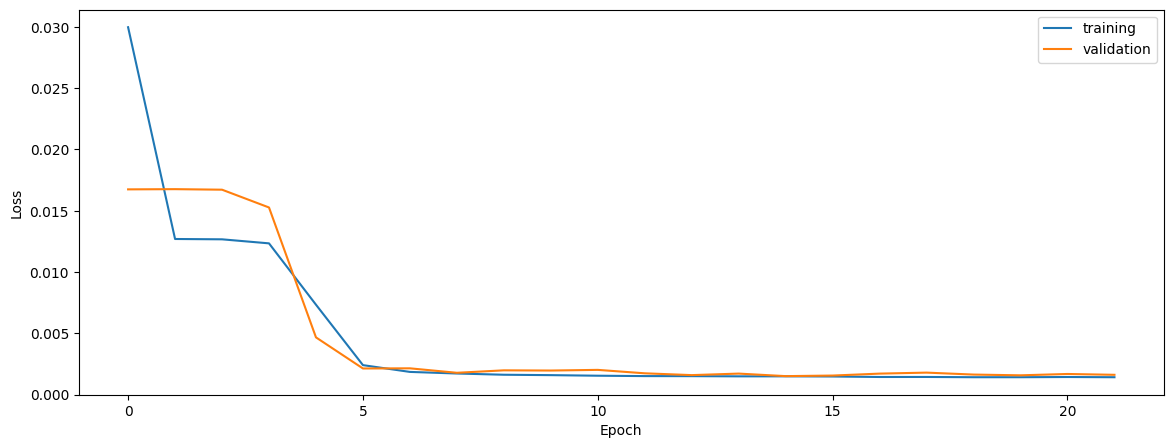

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.9408233742962304
0.9537313510350138
0.9511761064934274


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('native')
print(getPearson(train2[1],train_pred2))
print(getPearson(val2[1],val_pred2))
print(getPearson(test2[1],test_pred2))

native
0.9408233742962304
0.9537313510350138
0.9511761064934274


In [9]:
print('normalized')
print(getPearson(train2[1][train2[2]],train_pred2[train2[2]]))
print(getPearson(val2[1][val2[2]],val_pred2[val2[2]]))
print(getPearson(test2[1][test2[2]],test_pred2[test2[2]]))

normalized
0.9479312785790266
0.956624300245712
0.9631761846228998


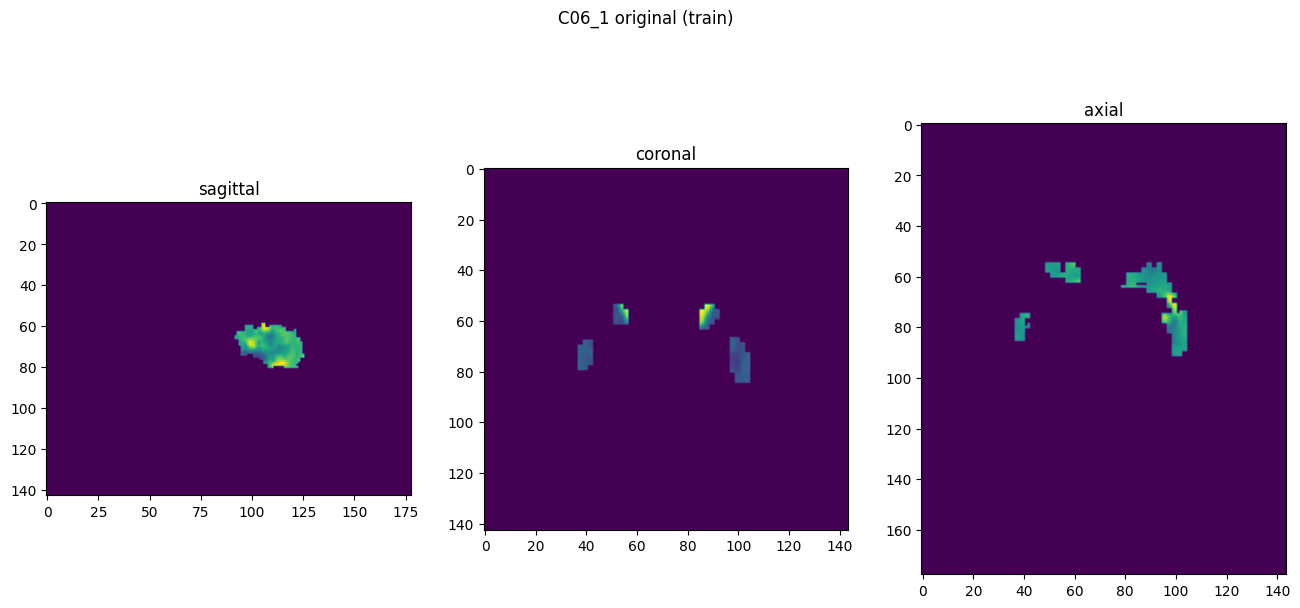

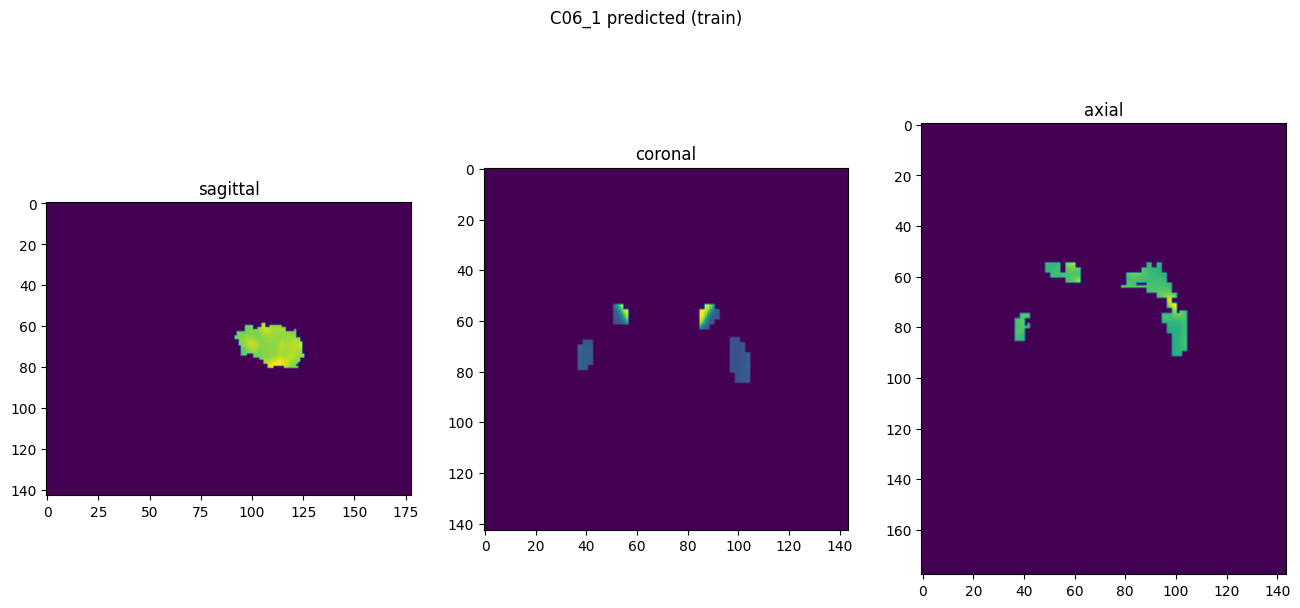

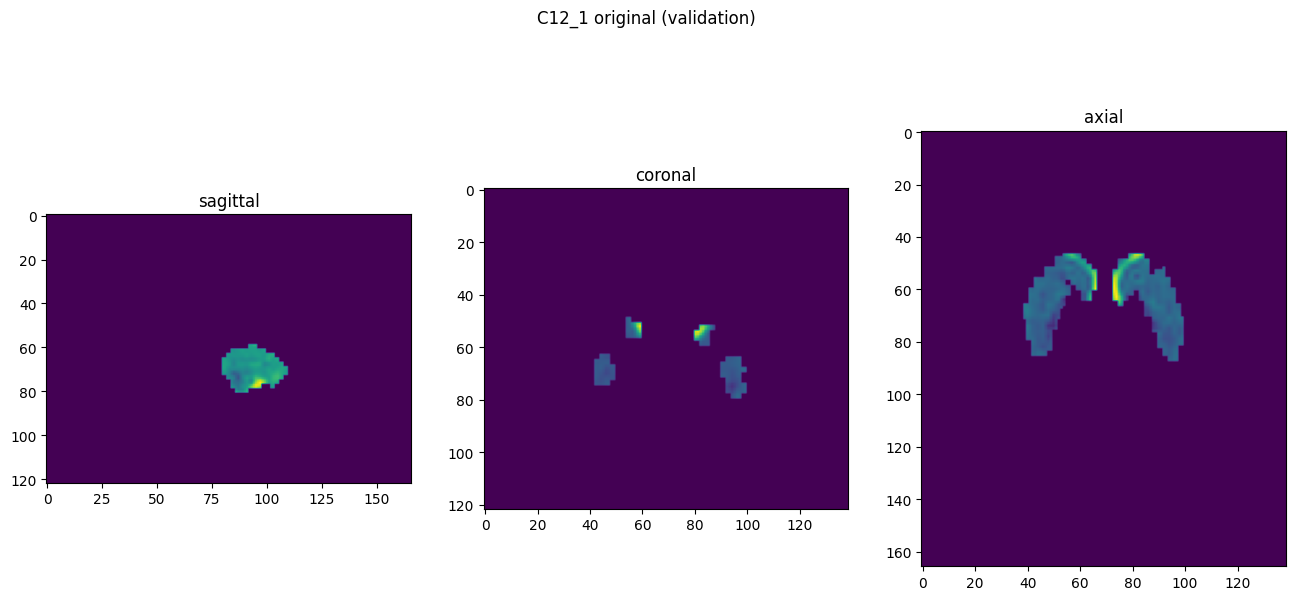

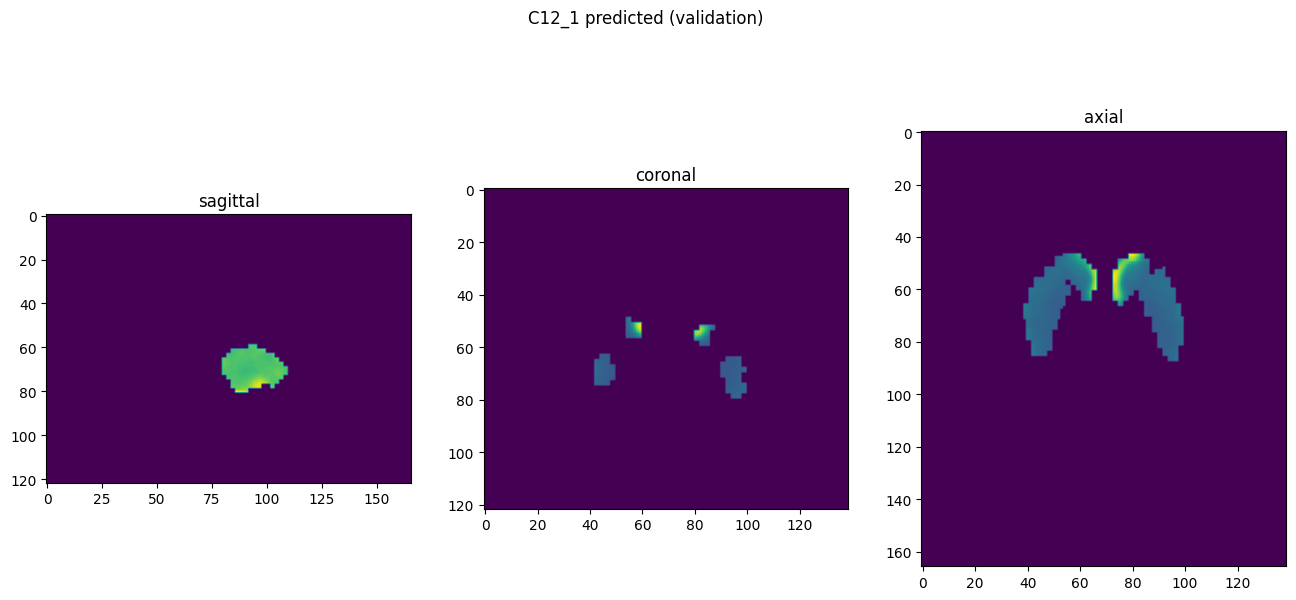

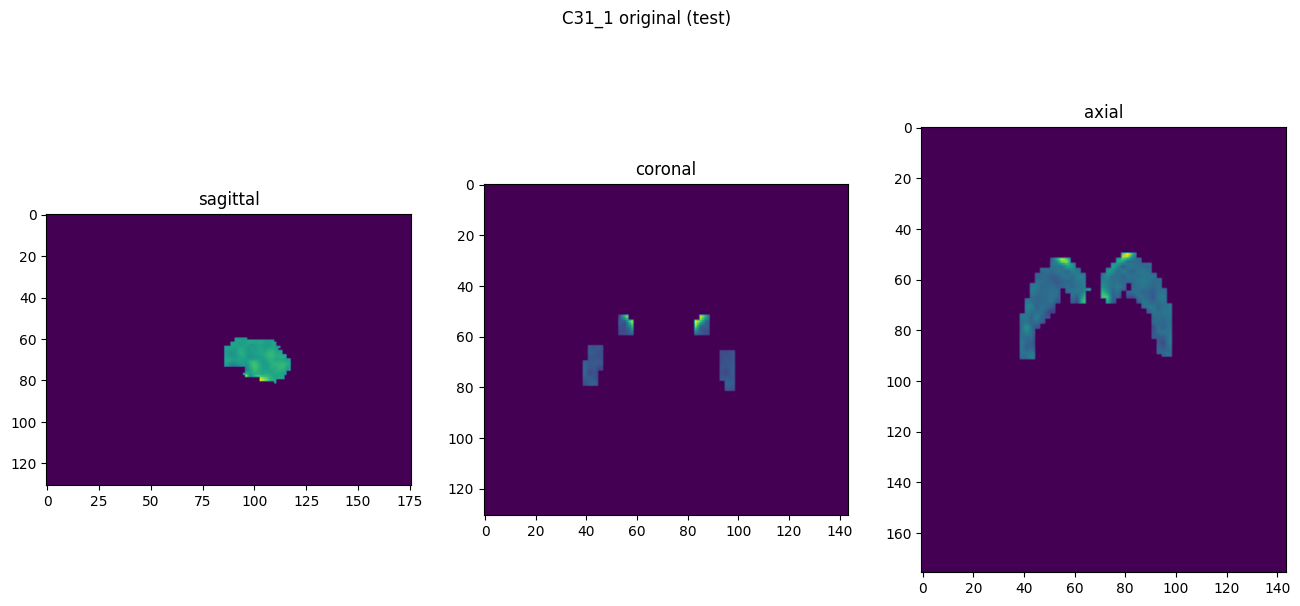

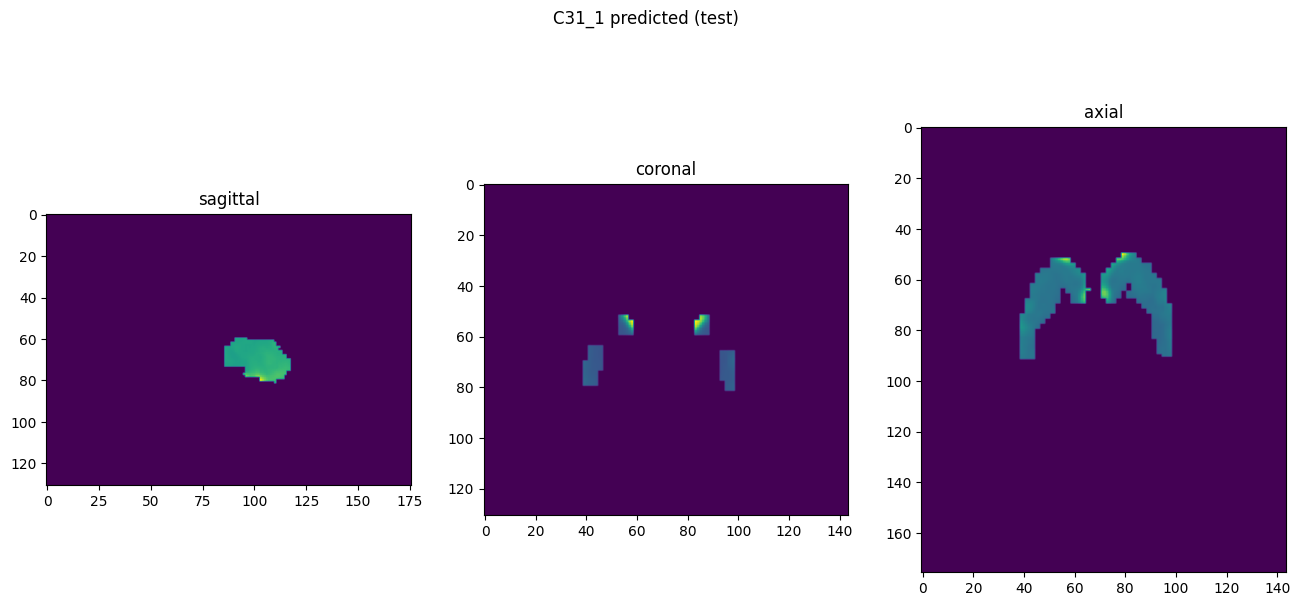

In [10]:
showResults(model, gen, threshold=None, background=False)